In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.beta import Beta
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
class Config:
    def __init__(self, lam=0.0, sampling_steps=1):
        self.n_samples = 6000
        self.noise_level = 0.05
        self.batch_size = 256
        self.epochs = 200
        self.lr = 1e-3
        self.hidden_dim = 256
        self.n_layers = 4
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # --- UCGM 训练/采样参数 ---
        self.lam = lam
        self.sampling_steps = sampling_steps
        self.rho = self.lam # rho 跟随 lam
        self.kesi = 0.0
        self.theta1 = 1.0
        self.theta2 = 1.0
        self.xi_func_s = 0.75
        self.eps = 5e-3
        self.n_generated_samples = 2000
        self.nu = 1
        self.kappa = 0.0
        self.kuma_a = 1.17
        self.kuma_b = 0.8
        self.kuma_c = 1.1

In [14]:
# --- UCGM Helper Functions ---

def alpha(t): return t
def gamma(t): return 1.0 - t
def alpha_hat(t): return torch.ones_like(t)
def gamma_hat(t): return -torch.ones_like(t)

def fx(Ft, xt, t):
    a_t, g_t, ah_t, gh_t = alpha(t.view(-1, 1)), gamma(t.view(-1, 1)), alpha_hat(t.view(-1, 1)), gamma_hat(t.view(-1, 1))
    denominator = a_t * gh_t - ah_t * g_t
    numerator = a_t * Ft - ah_t * xt
    return numerator / denominator

def fz(Ft, xt, t):
    a_t, g_t, ah_t, gh_t = alpha(t.view(-1, 1)), gamma(t.view(-1, 1)), alpha_hat(t.view(-1, 1)), gamma_hat(t.view(-1, 1))
    denominator = a_t * gh_t - ah_t * g_t
    numerator = gh_t * xt - g_t * Ft
    return numerator / denominator

def kuma_transform(T, a=1.17, b=0.8, c=1.1):
    """Applies the Kumaraswamy distribution transform."""
    return (1 - (1 - np.power(T, a))**b)**c

def generate_time_schedule(N, T=None, a=1.17, b=0.8, c=1.1):
    """Generates a non-linear time schedule from 0 to 1."""
    if T is None:
        T = np.linspace(0, 1, N)
    return kuma_transform(T, a, b, c)

In [15]:
# --- Define Neural Network F_theta
class MLP(nn.Module):
    def __init__(self, input_dim=3, output_dim=2, hidden_dim=256, n_layers=4):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.SiLU()]
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.SiLU()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        if t.ndim == 0: t = t.unsqueeze(0)
        if t.ndim == 1: t = t.unsqueeze(1)
        t_expanded = t.expand(x.size(0), 1)
        net_input = torch.cat([x, t_expanded], dim=1)
        return self.net(net_input)

In [16]:
# Data preparation function
def get_dataloader(config):
    x1_np, _ = make_moons(n_samples=config.n_samples, noise=config.noise_level)
    x1 = torch.tensor(x1_np, dtype=torch.float32)
    dataset = TensorDataset(x1)
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
    return dataloader, x1_np

In [17]:
# training loop for UCGM
def train(model, dataloader, optimizer, config):
    model.train()
    criterion = nn.MSELoss(reduction='none')
    time_sampler = Beta(torch.tensor([config.theta1]), torch.tensor([config.theta2]))
    def xi_func(a_xi, t_xi, b_xi, d_xi, s=config.xi_func_s):
        indicator = (t_xi > s).float()
        return a_xi + (config.kesi + indicator * (0.5-config.kesi)) * (b_xi - indicator * a_xi - d_xi * (1 - indicator))

    print("Start Training UCGM")
    for epoch in range(config.epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()

            # sample
            x = batch[0].to(config.device)
            z = torch.randn_like(x)
            t = time_sampler.sample((x.size(0),)).squeeze(-1).to(config.device)

            # compute input data
            a_t, g_t = alpha(t.view(-1, 1)), gamma(t.view(-1, 1))
            ah_t, gh_t = alpha_hat(t.view(-1, 1)), gamma_hat(t.view(-1, 1))
            a_lamt, g_lamt= alpha((config.lam * t).view(-1, 1)), gamma((config.lam * t).view(-1, 1))
            a_t_plus, g_t_plus ,a_t_minus, g_t_minus = alpha((t+config.eps).view(-1, 1)), gamma((t+config.eps).view(-1, 1)), alpha((t-config.eps).view(-1, 1)), gamma((t-config.eps).view(-1, 1))
            x_t = a_t * z + g_t * x
            x_lamt = a_lamt * z + g_lamt * x

            # compute model output
            F_t = model(x_t, t)
            x_star, z_star = x, z
            F_t_sg = F_t.detach()

            if 0<config.kesi<1:
                F_t_empty = F_t.detach()
                x_star = xi_func(x, t, fx(F_t_sg,x_t,t),fx(F_t_empty,x_t,t))
                z_star = xi_func(z, t, fz(F_t_sg,x_t,t),fz(F_t_empty,x_t,t))

            if 0<=config.lam<1:
                x_t_star = a_t * z_star + g_t * x_star
                x_lamt_star = a_lamt * z_star + g_lamt * x_star
                lam_t = config.lam * t
                F_lamt_sg = model(x_lamt,lam_t).detach()
                delta_fx = fx(F_t_sg, x_t_star, t) / (t - lam_t).view(-1,1) - fx(F_lamt_sg, x_lamt_star, lam_t) / (t - lam_t).view(-1,1)

            elif config.lam==1:
                x_t_star_plus = a_t_plus * z_star + g_t_plus * x_star
                x_t_star_minus = a_t_minus * z_star + g_t_minus * x_star
                t_plus = t + config.eps
                t_minus = t - config.eps
                F_sg_plus = model(x_t_star_plus, t_plus).detach()
                F_sg_minus = model(x_t_star_minus, t_minus).detach()
                delta_fx = fx(F_sg_plus,x_t_star_plus, t_plus)/(2*config.eps)-fx(F_sg_minus, x_t_star_minus, t_minus)/(2*config.eps)

            # compute target
            denom_wronskian = a_t * gamma_hat(t.view(-1, 1)) - alpha_hat(t.view(-1, 1)) * g_t
            clipped_delta = torch.clip(delta_fx, -1.0, 1.0)
            correction_term = (4 * a_t / denom_wronskian) * (clipped_delta / (torch.sin(t.view(-1,1)) + 1e-8))
            F_target = F_t_sg - correction_term

            # compute loss
            loss_per_sample = criterion(F_t, F_target).mean(dim=1)
            weights = torch.cos(t)
            loss = (loss_per_sample * weights).mean()

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{config.epochs}, 平均损失: {avg_loss:.4f}")



In [18]:
# UCGM Sampler
@torch.no_grad()
def sample(model, config, initial_noise, indices_to_plot):
    model.eval()

    # use the inputed initial noise
    x_tilde = initial_noise.clone().to(config.device)

    numpy_schedule = generate_time_schedule(
            N=config.sampling_steps + 1,
            a=config.kuma_a,
            b=config.kuma_b,
            c=config.kuma_c
        )
    time_schedule = torch.tensor(numpy_schedule[::-1].copy(), dtype=torch.float32, device=config.device)

    points_to_track = x_tilde[indices_to_plot]
    trajectory = [points_to_track.cpu().numpy()]
    x_hat_list = []
    z_hat_list = []

    print(f"Start UCGM training (lam={config.lam}, steps={config.sampling_steps})...")


    if config.nu == 2:
        N = (N+1)//2
    for i in tqdm(range(config.sampling_steps), desc="Sampling"):
        t_current = time_schedule[i]
        t_next = time_schedule[i+1]

        F = model(x_tilde, t_current).detach()
        x_hat_list.append(fx(F, x_tilde, t_current))
        z_hat_list.append(fz(F, x_tilde, t_current))
        if i==0:
            z_hat = z_hat_list[i]
            x_hat = x_hat_list[i]

        if i>=1:
            z_hat = z_hat_list[i] + config.kappa * (z_hat_list[i]-z_hat_list[i-1])
            x_hat = x_hat_list[i] + config.kappa * (x_hat_list[i]-x_hat_list[i-1])

        z = torch.randn(config.n_generated_samples, 2).to(config.device)

        a_t, g_t = alpha(t_current), gamma(t_current)
        a_next, g_next = alpha(t_next), gamma(t_next)
        x_prime = a_next * (math.sqrt(1-config.rho) * z_hat + math.sqrt(config.rho)*z) + g_next * x_hat

        if config.nu == 2 and i < config.sampling_steps-1:
            F_prime = model(x_prime, t_next).detach()
            x_hat_prime = fx(F_prime, x_prime, t_next)
            z_hat_prime = fz(F_prime, x_prime, t_next)
            x_prime = x_tilde * (g_next / g_t) + (a_next - g_next * a_t / g_t) * (x_hat + x_hat_prime) / 2

        x_tilde = x_prime
        points_to_track = x_tilde[indices_to_plot]
        trajectory.append(points_to_track.cpu().numpy())

    return x_tilde.cpu().numpy(), np.array(trajectory)

In [19]:
def plot_single_run(original_data, final_points, trajectory, title):
    plt.figure(figsize=(10, 10))

    plt.scatter(final_points[:, 0], final_points[:, 1], alpha=0.2, s=15, color='gray', label='All Generated Points')


    num_trajectories = trajectory.shape[1]
    for i in range(num_trajectories):
        plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], alpha=0.8)

    plt.scatter(trajectory[0, :, 0], trajectory[0, :, 1], c='b', s=50, label='Start (Noise)', zorder=5)
    plt.scatter(trajectory[-1, :, 0], trajectory[-1, :, 1], c='r', s=50, label='End (Tracked)', zorder=5)

    plt.title(title)
    plt.xlabel("X1"); plt.ylabel("X2"); plt.legend()
    plt.grid(True, linestyle='--'); plt.axis('equal'); plt.show()


def plot_trajectory_comparison(original_data, traj1, traj2, label1, label2):
    plt.figure(figsize=(12, 12))

    # draw target distribution of 2 moons
    plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.1, s=15, color='gray', label='Target Distribution')

    num_trajectories = traj1.shape[1]
    for i in range(num_trajectories):
        plt.plot(traj1[:, i, 0], traj1[:, i, 1], color='C0', alpha=0.8, linewidth=2.0)
        plt.plot(traj2[:, i, 0], traj2[:, i, 1], color='C1', alpha=0.8, linewidth=2.0, linestyle='--')


    start_points = traj1[0, :, :]
    plt.scatter(start_points[:, 0], start_points[:, 1], c='black', s=100, label='Start (Shared Noise)', zorder=5, marker='X')

    end_points1 = traj1[-1, :, :]
    plt.scatter(end_points1[:, 0], end_points1[:, 1], c='darkblue', s=120, label=f'End ({label1})', zorder=5, marker='*')

    end_points2 = traj2[-1, :, :]
    plt.scatter(end_points2[:, 0], end_points2[:, 1], c='darkorange', s=120, label=f'End ({label2})', zorder=5, marker='o')

    plt.title("Comparison of Trajectories")
    plt.xlabel("X1"); plt.ylabel("X2"); plt.legend()
    plt.grid(True, linestyle='--'); plt.axis('equal'); plt.show()

--- Step 1: Preparing fixed initial noise and indices ---
Selected 5 points for visualization: [ 588 1144  764   19  134]

--- Running Experiment 1: lam=0.0, 40 steps ---
Start Training UCGM


Epoch 10/200: 100%|██████████| 23/23 [00:00<00:00, 176.23it/s, Loss=7.9271]


Epoch 10/200, 平均损失: 7.8567


Epoch 20/200: 100%|██████████| 23/23 [00:00<00:00, 153.49it/s, Loss=8.2042]


Epoch 20/200, 平均损失: 7.6623


Epoch 30/200: 100%|██████████| 23/23 [00:00<00:00, 170.72it/s, Loss=7.4980]


Epoch 30/200, 平均损失: 7.5805


Epoch 40/200: 100%|██████████| 23/23 [00:00<00:00, 192.15it/s, Loss=7.5368]


Epoch 40/200, 平均损失: 7.5255


Epoch 50/200: 100%|██████████| 23/23 [00:00<00:00, 190.34it/s, Loss=7.2159]


Epoch 50/200, 平均损失: 7.5093


Epoch 60/200: 100%|██████████| 23/23 [00:00<00:00, 188.16it/s, Loss=7.4206]


Epoch 60/200, 平均损失: 7.2819


Epoch 70/200: 100%|██████████| 23/23 [00:00<00:00, 188.67it/s, Loss=7.5105]


Epoch 70/200, 平均损失: 7.3408


Epoch 80/200: 100%|██████████| 23/23 [00:00<00:00, 189.08it/s, Loss=7.6378]


Epoch 80/200, 平均损失: 7.4389


Epoch 90/200: 100%|██████████| 23/23 [00:00<00:00, 191.03it/s, Loss=7.1612]


Epoch 90/200, 平均损失: 7.3118


Epoch 100/200: 100%|██████████| 23/23 [00:00<00:00, 189.21it/s, Loss=7.1508]


Epoch 100/200, 平均损失: 7.3345


Epoch 110/200: 100%|██████████| 23/23 [00:00<00:00, 176.57it/s, Loss=7.6115]


Epoch 110/200, 平均损失: 7.4051


Epoch 120/200: 100%|██████████| 23/23 [00:00<00:00, 186.88it/s, Loss=7.2798]


Epoch 120/200, 平均损失: 7.2273


Epoch 130/200: 100%|██████████| 23/23 [00:00<00:00, 195.00it/s, Loss=7.2153]


Epoch 130/200, 平均损失: 7.2719


Epoch 140/200: 100%|██████████| 23/23 [00:00<00:00, 194.32it/s, Loss=7.3116]


Epoch 140/200, 平均损失: 7.1832


Epoch 150/200: 100%|██████████| 23/23 [00:00<00:00, 190.95it/s, Loss=7.5357]


Epoch 150/200, 平均损失: 7.2226


Epoch 160/200: 100%|██████████| 23/23 [00:00<00:00, 186.72it/s, Loss=7.0823]


Epoch 160/200, 平均损失: 7.2491


Epoch 170/200: 100%|██████████| 23/23 [00:00<00:00, 194.19it/s, Loss=7.3468]


Epoch 170/200, 平均损失: 7.3056


Epoch 180/200: 100%|██████████| 23/23 [00:00<00:00, 192.21it/s, Loss=7.2888]


Epoch 180/200, 平均损失: 7.3196


Epoch 190/200: 100%|██████████| 23/23 [00:00<00:00, 187.20it/s, Loss=7.6541]


Epoch 190/200, 平均损失: 7.2691


Epoch 200/200: 100%|██████████| 23/23 [00:00<00:00, 191.66it/s, Loss=7.7260]


Epoch 200/200, 平均损失: 7.2332
Start UCGM training (lam=0.0, steps=40)...


Sampling: 100%|██████████| 40/40 [00:00<00:00, 955.24it/s]



--- Running Experiment 2: lam=1.0, 1 step ---
Start Training UCGM


Epoch 10/200: 100%|██████████| 23/23 [00:00<00:00, 178.70it/s, Loss=8.0947]


Epoch 10/200, 平均损失: 7.9119


Epoch 20/200: 100%|██████████| 23/23 [00:00<00:00, 178.29it/s, Loss=8.0796]


Epoch 20/200, 平均损失: 7.8835


Epoch 30/200: 100%|██████████| 23/23 [00:00<00:00, 161.63it/s, Loss=7.5856]


Epoch 30/200, 平均损失: 7.8148


Epoch 40/200: 100%|██████████| 23/23 [00:00<00:00, 164.84it/s, Loss=6.8812]


Epoch 40/200, 平均损失: 7.6849


Epoch 50/200: 100%|██████████| 23/23 [00:00<00:00, 171.04it/s, Loss=7.5052]


Epoch 50/200, 平均损失: 7.4674


Epoch 60/200: 100%|██████████| 23/23 [00:00<00:00, 177.77it/s, Loss=7.3034]


Epoch 60/200, 平均损失: 7.6471


Epoch 70/200: 100%|██████████| 23/23 [00:00<00:00, 177.95it/s, Loss=6.8751]


Epoch 70/200, 平均损失: 7.3218


Epoch 80/200: 100%|██████████| 23/23 [00:00<00:00, 175.86it/s, Loss=6.9646]


Epoch 80/200, 平均损失: 7.1834


Epoch 90/200: 100%|██████████| 23/23 [00:00<00:00, 166.35it/s, Loss=6.5482]


Epoch 90/200, 平均损失: 7.0470


Epoch 100/200: 100%|██████████| 23/23 [00:00<00:00, 178.98it/s, Loss=7.1936]


Epoch 100/200, 平均损失: 6.9791


Epoch 110/200: 100%|██████████| 23/23 [00:00<00:00, 76.86it/s, Loss=6.9987] 


Epoch 110/200, 平均损失: 6.9065


Epoch 120/200: 100%|██████████| 23/23 [00:00<00:00, 181.58it/s, Loss=7.1824]


Epoch 120/200, 平均损失: 7.0664


Epoch 130/200: 100%|██████████| 23/23 [00:00<00:00, 181.04it/s, Loss=6.4913]


Epoch 130/200, 平均损失: 7.0291


Epoch 140/200: 100%|██████████| 23/23 [00:00<00:00, 177.92it/s, Loss=6.9771]


Epoch 140/200, 平均损失: 6.8741


Epoch 150/200: 100%|██████████| 23/23 [00:00<00:00, 179.69it/s, Loss=7.1717]


Epoch 150/200, 平均损失: 6.9175


Epoch 160/200: 100%|██████████| 23/23 [00:00<00:00, 171.53it/s, Loss=7.7059]


Epoch 160/200, 平均损失: 6.9901


Epoch 170/200: 100%|██████████| 23/23 [00:00<00:00, 173.32it/s, Loss=6.8842]


Epoch 170/200, 平均损失: 6.7402


Epoch 180/200: 100%|██████████| 23/23 [00:00<00:00, 179.08it/s, Loss=6.7091]


Epoch 180/200, 平均损失: 6.7706


Epoch 190/200: 100%|██████████| 23/23 [00:00<00:00, 180.19it/s, Loss=7.2960]


Epoch 190/200, 平均损失: 6.7778


Epoch 200/200: 100%|██████████| 23/23 [00:00<00:00, 184.70it/s, Loss=7.4968]


Epoch 200/200, 平均损失: 6.9689
Start UCGM training (lam=1.0, steps=1)...


Sampling: 100%|██████████| 1/1 [00:00<00:00, 783.25it/s]



--- Plotting Results ---


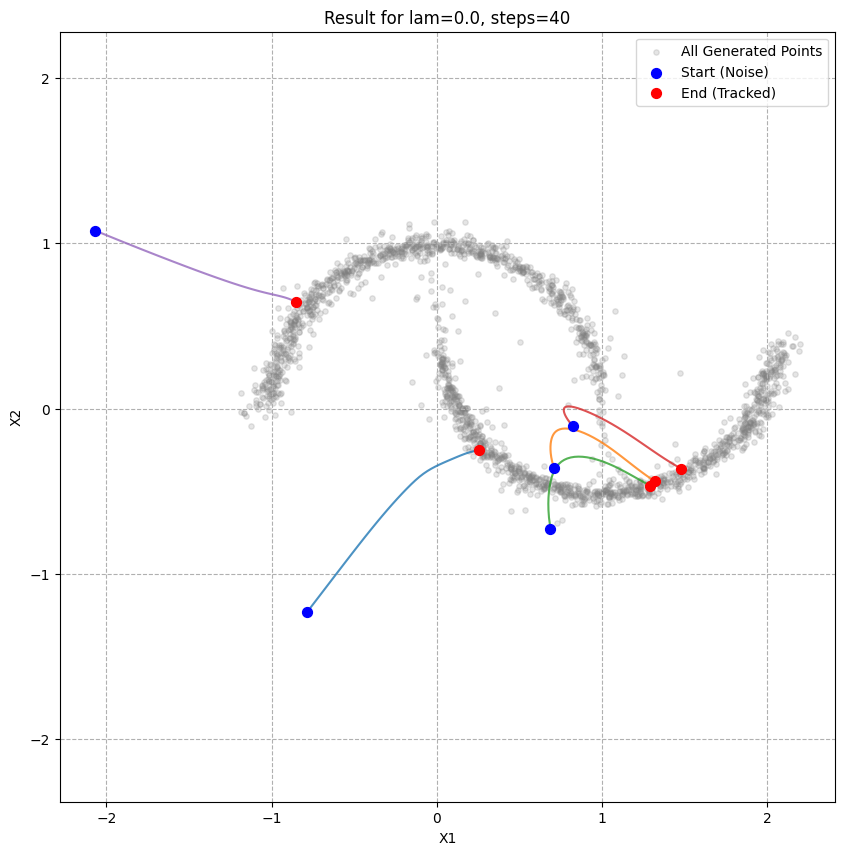

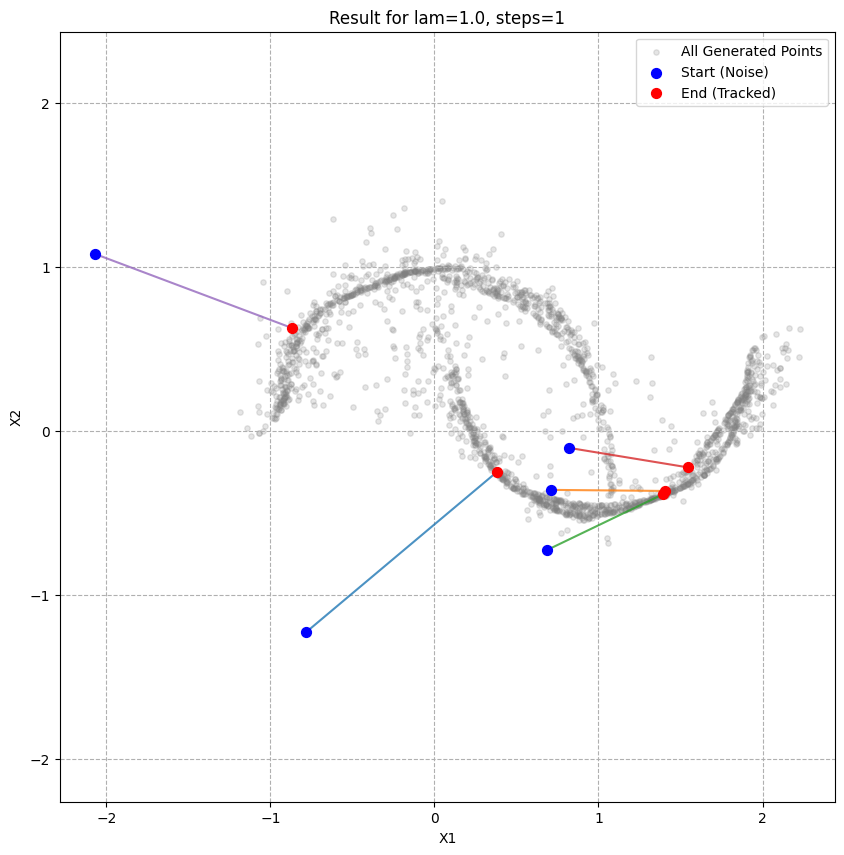

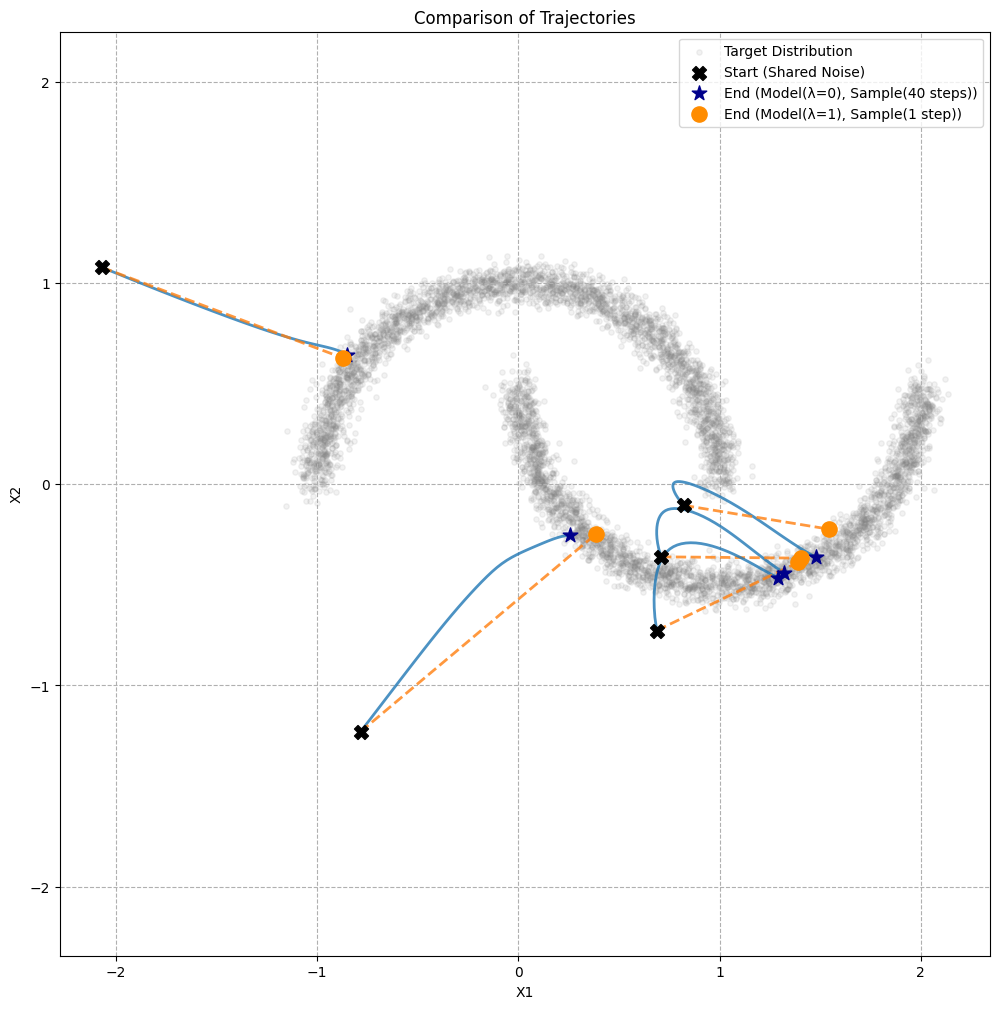

In [20]:
if __name__ == "__main__":
    master_config = Config()
    dataloader, original_data = get_dataloader(master_config)

    print("--- Step 1: Preparing fixed initial noise and indices ---")
    initial_noise = torch.randn(master_config.n_generated_samples, 2)
    indices_to_plot = np.random.choice(master_config.n_generated_samples, 5, replace=False)
    print(f"Selected 5 points for visualization: {indices_to_plot}")

    # --- Run 1: lam=0.0 (train) -> 40 steps (sample) ---
    print("\n--- Running Experiment 1: lam=0.0, 40 steps ---")
    config1 = Config(lam=0.0, sampling_steps=40)
    model1 = MLP(input_dim=3, output_dim=2, hidden_dim=config1.hidden_dim, n_layers=config1.n_layers).to(config1.device)
    optimizer1 = optim.Adam(model1.parameters(), lr=config1.lr)
    train(model1, dataloader, optimizer1, config1)
    final_points1, trajectory1 = sample(model1, config1, initial_noise, indices_to_plot)

    # --- Run 2: lam=1.0 (train) -> 1 step (sample) ---
    print("\n--- Running Experiment 2: lam=1.0, 1 step ---")
    config2 = Config(lam=1.0, sampling_steps=1)
    model2 = MLP(input_dim=3, output_dim=2, hidden_dim=config2.hidden_dim, n_layers=config2.n_layers).to(config2.device)
    optimizer2 = optim.Adam(model2.parameters(), lr=config2.lr)
    train(model2, dataloader, optimizer2, config2)
    final_points2, trajectory2 = sample(model2, config2, initial_noise, indices_to_plot)

    # --- Step 3: Visualization ---
    print("\n--- Plotting Results ---")

    # Figure1: result of Config1
    plot_single_run(
        original_data,
        final_points1,
        trajectory1,
        title=f'Result for lam={config1.lam}, steps={config1.sampling_steps}'
    )

    # Figure2: result of Config2
    plot_single_run(
        original_data,
        final_points2,
        trajectory2,
        title=f'Result for lam={config2.lam}, steps={config2.sampling_steps}'
    )

    # Figure3: compare the trajectory
    plot_trajectory_comparison(
        original_data,
        trajectory1,
        trajectory2,
        label1=f'Model(λ=0), Sample(40 steps)',
        label2=f'Model(λ=1), Sample(1 step)'
    )